# Preparing our image for contour generation

### Steps
1. Smoothing
2. Foreground/background segmentation
3. Hole-filling
4. Island removal

### Setup

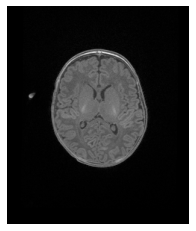

In [2]:

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from filters_helpers import get_img, disp_center_axial_slice

img: sitk.Image = get_img('../ExampleData/MicroBiome_1month_T1w.nii.gz')
disp_center_axial_slice(img)

### Smoothing
First, we smooth the image to reduce noise. We will use the `GradientAnisotropicDiffusionImageFilter` to accomplish this task because of its [edge-preserving properties](https://en.wikipedia.org/wiki/Edge-preserving_smoothing).

In [3]:
anisotropic_diffusion_filter = sitk.GradientAnisotropicDiffusionImageFilter()

The `GradientAnisotropicDiffusionImageFilter` has [several parameters](https://slicer.readthedocs.io/en/latest/user_guide/modules/gradientanisotropicdiffusion.html) that the user can set. We will set the time step to 0.04 for a stable solution. 

In [4]:
STABLE_TIME_STEP = 0.04

anisotropic_diffusion_filter.SetTimeStep(STABLE_TIME_STEP)

Also, we will set the conductance parameter. The lower its value, the more strongly edges are preserved.

**Note:**

We have to cast our image to `sitkFloat64` for the `GradientAnisotropicDiffusionImageFilter` to work properly.

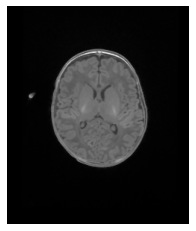

In [5]:
CONDUCTANCE_PARAMETER = 3.0

anisotropic_diffusion_filter.SetConductanceParameter(CONDUCTANCE_PARAMETER)
smooth_img: sitk.Image = anisotropic_diffusion_filter.Execute(sitk.Cast(img, sitk.sitkFloat64))
disp_center_axial_slice(smooth_img)

### Foreground/Background Segmentation
Now we will segment our image into a foreground and background. This helps us eventually generate a contour of our image.

The `OtsuThresholdImageFilter` is one way to segment the image. It automatically computes a threshold.

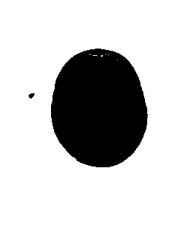

In [6]:
otsu_img: sitk.Image = sitk.OtsuThresholdImageFilter().Execute(smooth_img)
disp_center_axial_slice(otsu_img)

We could also use the `BinaryThresholdImageFilter` if we want to specify a lower and upper threshold.

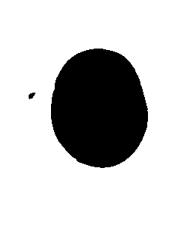

In [7]:

LOWER_THRESHOLD = 0.0
UPPER_THRESHOLD = 100.0

binary_threshold_filter: sitk.Image = sitk.BinaryThresholdImageFilter()
binary_threshold_filter.SetLowerThreshold(LOWER_THRESHOLD)
binary_threshold_filter.SetUpperThreshold(UPPER_THRESHOLD)
binary_img: sitk.Image = binary_threshold_filter.Execute(smooth_img)
disp_center_axial_slice(binary_img)

### Hole-Filling
Often, the result of our foreground/background segmentation has holes. If we were to generate a contour at this point, each of the holes would have its own contour. However, we only want to generate a contour for the head. So, we will use the `BinaryGrindPeakImageFilter` to remove any holes.

**Note:**

The previous processing steps result in an inverted image (i.e. the pixels representing the head are 0 as opposed to 1). For the `BinaryGrindPeakImageFilter` to work as expected, our image must remain inverted.

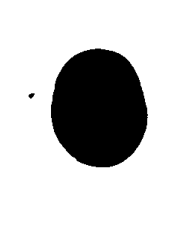

In [8]:
no_holes_img: sitk.Image = sitk.BinaryGrindPeakImageFilter().Execute(otsu_img)
disp_center_axial_slice(no_holes_img)

### Island Removal
Sometimes an image is very noisy. This can result in small islands being scattered throughout the image. These islands will result in the generation of additonal contours, so we will remove them from our image. We can do so by selecting the largest component using the `ConnectedComponentImageFilter`.

**Note:**

The largest component selection algorithm relies upon our image not being inverted. We must use the `NotImageFilter` for a non-inverted image.

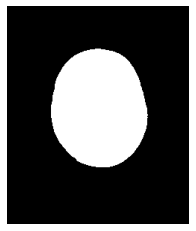

In [9]:
noninverted_img: sitk.Image = sitk.NotImageFilter().Execute(no_holes_img)
component_image = sitk.ConnectedComponentImageFilter().Execute(noninverted_img)
sorted_component_image = sitk.RelabelComponent(
    component_image, sortByObjectSize=True
)
largest_component = sorted_component_image == 1
disp_center_axial_slice(largest_component)

### Now after these 4 steps, we are ready to find the contour of this brain slice.

In [10]:
import cv2
import numpy as np
import SimpleITK as sitk

#some helper functions

def transfer_to_2D(img_3d: sitk.Image) -> np.ndarray:
    z_center: int = (img_3d.GetSize()[2] - 1) // 2
    slice_axial: sitk.Image = img_3d[:, :, z_center]
    img_2d = sitk.GetArrayFromImage(slice_axial)
    return img_2d

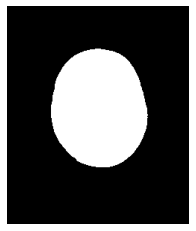

number of the contours we find in this img: 1
length of the contour: 481.10259330272675


In [11]:

# find the contour using function "findContours" in cv2

disp_center_axial_slice(largest_component)

contours, hierarchy = cv2.findContours(
        transfer_to_2D(largest_component), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
)

# cv2.RETR_TREE: The contours are returned as a list of all contours found in the image and their hierarchical relationships are represented as a tree structure.
# cv2.CHAIN_APPROX_SIMPLE: Produces a set of connected edges. This approximation method helps to reduce the storage and computational requirements for representing contours.

num_contours: int = len(contours)
print("number of the contours we find in this img: " + str(num_contours))

parent_contour: np.ndarray = contours[0]
# True means we assume the contour is a closed curve.
arc_length = cv2.arcLength(parent_contour, True)
print("length of the contour: " + str(arc_length))

In [12]:

# Let's see how many contours we have in a previous image ->
contours_before_processing1, hierarchy = cv2.findContours(
        transfer_to_2D(binary_img), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
)

num_contours2: int = len(contours_before_processing1)
print("number of the contours we find in this img: " + str(num_contours2))

for i in contours_before_processing1:
    print("length of the contour: " + str(cv2.arcLength(i, True)))

print(" ")
contours_before_processing2, hierarchy = cv2.findContours(
        transfer_to_2D(otsu_img), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
)

num_contours3: int = len(contours_before_processing2)
print("number of the contours we find in this img: " + str(num_contours3))

for i in contours_before_processing2:
    print("length of the contour: " + str(cv2.arcLength(i, True)))

number of the contours we find in this img: 3
length of the contour: 1068.0
length of the contour: 32.3847758769989
length of the contour: 488.17366087436676
 
number of the contours we find in this img: 9
length of the contour: 1068.0
length of the contour: 26.97056233882904
length of the contour: 486.75944805145264
length of the contour: 0.0
length of the contour: 5.414213538169861
length of the contour: 10.0
length of the contour: 0.0
length of the contour: 0.0
length of the contour: 2.0


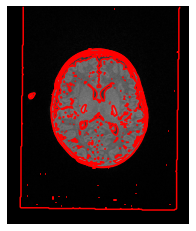

In [13]:

# Visualize the contour using QImage methods
contour_img = sitk.LabelContour(img, fullyConnected=True)

# When fullyConnected is set to True, the algorithm considers diagonal connections between pixels as valid connections, and the resulting contour is fully connected. 

plt.imshow(transfer_to_2D(img), cmap = "gray") #grayscale img
plt.contour(transfer_to_2D(contour_img), colors = "r")
plt.axis("off")
plt.show()

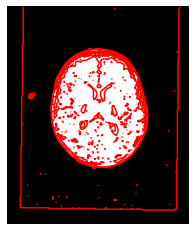

In [14]:
contour_img2 = sitk.LabelContour(largest_component, fullyConnected=True)

plt.imshow(transfer_to_2D(largest_component), cmap = "gray")
plt.contour(transfer_to_2D(contour_img), colors = "r")
plt.axis("off")
plt.show()

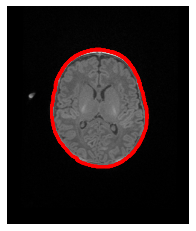

In [15]:
plt.imshow(transfer_to_2D(img), cmap = "gray")
plt.contour(transfer_to_2D(contour_img2), colors = "r")
plt.axis("off")
plt.show()